In [20]:

# 10_srs_adjusted_metrics.ipynb
# 📈 SRS-Based Opponent Adjustments

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = "./data"

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]

In [21]:
# 📂 Load 2023 advanced game stats and game metadata

game_stats = pd.read_csv(os.path.join(DATA_DIR, "advanced_game_stats", "2023.csv"))
games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))

# Filter only FBS games
games = games.query("season == 2023 and home_classification == 'fbs' and away_classification == 'fbs'")
stats = games[["id"]].merge(game_stats, how="inner", left_on="id", right_on="gameId")

# Focus on FBS teams only
teams = sorted(set(stats["team"]).union(set(stats["opponent"])))
team_idx = {team: i for i, team in enumerate(teams)}
n_teams = len(teams)

print(f"{n_teams} teams included")

/tmp/ipykernel_22908/976254600.py:4: DtypeWarning: Columns (5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))


133 teams included


In [22]:
# Solve: offense_rating[team] - defense_rating[opponent] ≈ offense_ppa

A_off = np.zeros((n_teams, n_teams))
b_off = np.zeros(n_teams)

for _, row in stats.iterrows():
    team = row["team"]
    opp = row["opponent"]
    ppa = row["offense_ppa"]

    if team in team_idx and opp in team_idx:
        i = team_idx[team]
        j = team_idx[opp]

        A_off[i][i] += 1
        A_off[i][j] -= 1
        b_off[i] += ppa

offense_rating = np.linalg.lstsq(A_off, b_off, rcond=None)[0]

In [23]:
# Solve: defense_rating[team] - offense_rating[opponent] ≈ defense_ppa

A_def = np.zeros((n_teams, n_teams))
b_def = np.zeros(n_teams)

for _, row in stats.iterrows():
    team = row["team"]
    opp = row["opponent"]
    ppa = row["defense_ppa"]

    if team in team_idx and opp in team_idx:
        i = team_idx[team]
        j = team_idx[opp]

        A_def[i][i] += 1
        A_def[i][j] -= 1
        b_def[i] += ppa

defense_rating = np.linalg.lstsq(A_def, b_def, rcond=None)[0]

In [24]:
srs_df = pd.DataFrame({
    "team": teams,
    "offense_srs": offense_rating,
    "defense_srs": defense_rating,
    "net_srs": offense_rating - defense_rating
}).sort_values("net_srs", ascending=False)

srs_df.head(10)

,team,offense_srs,defense_srs,net_srs
83,Oregon,0.528179,0.059691,0.468489
33,Georgia,0.303112,-0.096579,0.399691
78,Ohio State,0.024883,-0.346932,0.371815
76,Notre Dame,0.146748,-0.218446,0.365194
60,Michigan,0.053143,-0.290693,0.343835
85,Penn State,-0.033590,-0.353438,0.319848
79,Oklahoma,0.316659,-0.002953,0.319611
49,LSU,0.352995,0.048636,0.304359
65,Missouri,0.210825,-0.079519,0.290343
2,Alabama,0.193871,-0.080490,0.274361


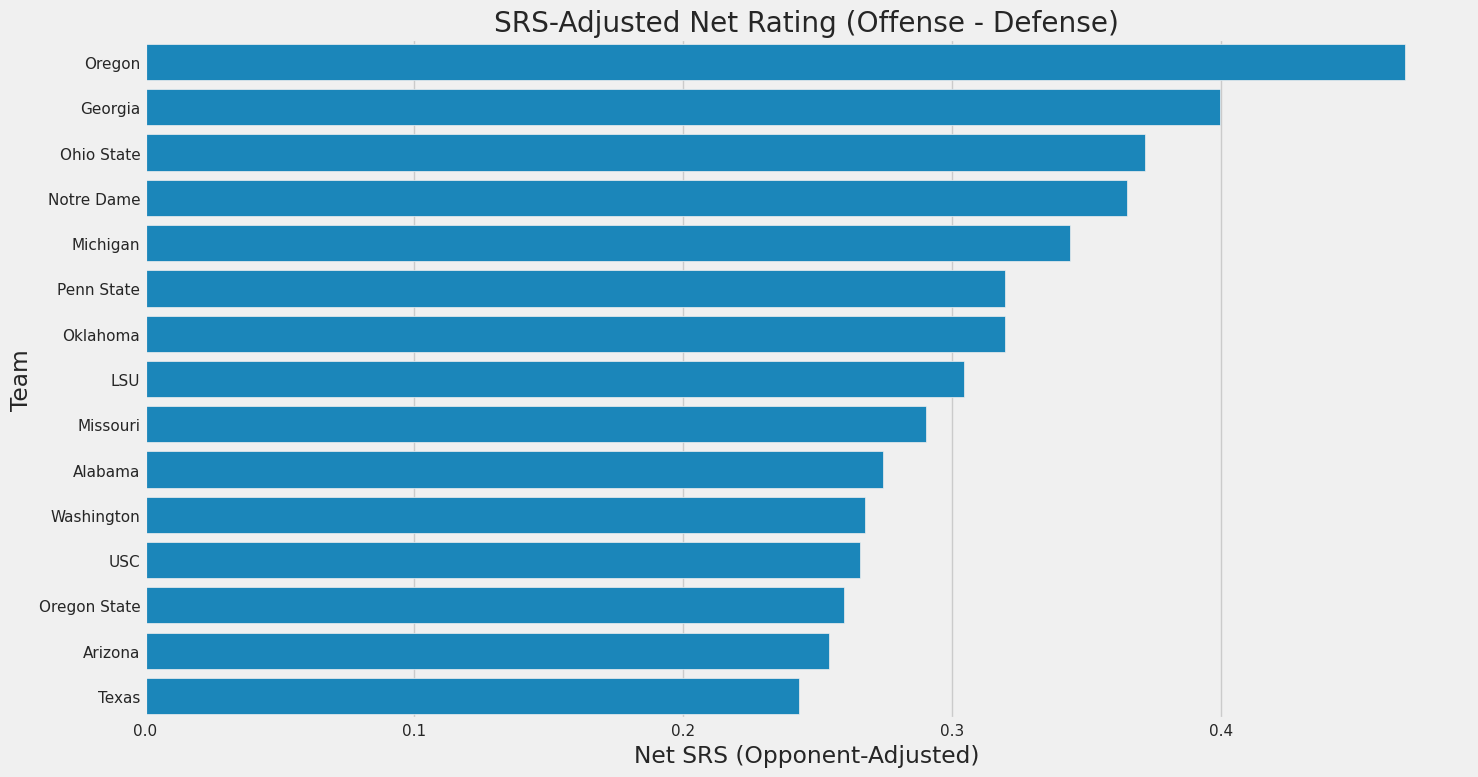

In [25]:
sns.barplot(data=srs_df.head(15), x="net_srs", y="team")
plt.title("SRS-Adjusted Net Rating (Offense - Defense)")
plt.xlabel("Net SRS (Opponent-Adjusted)")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

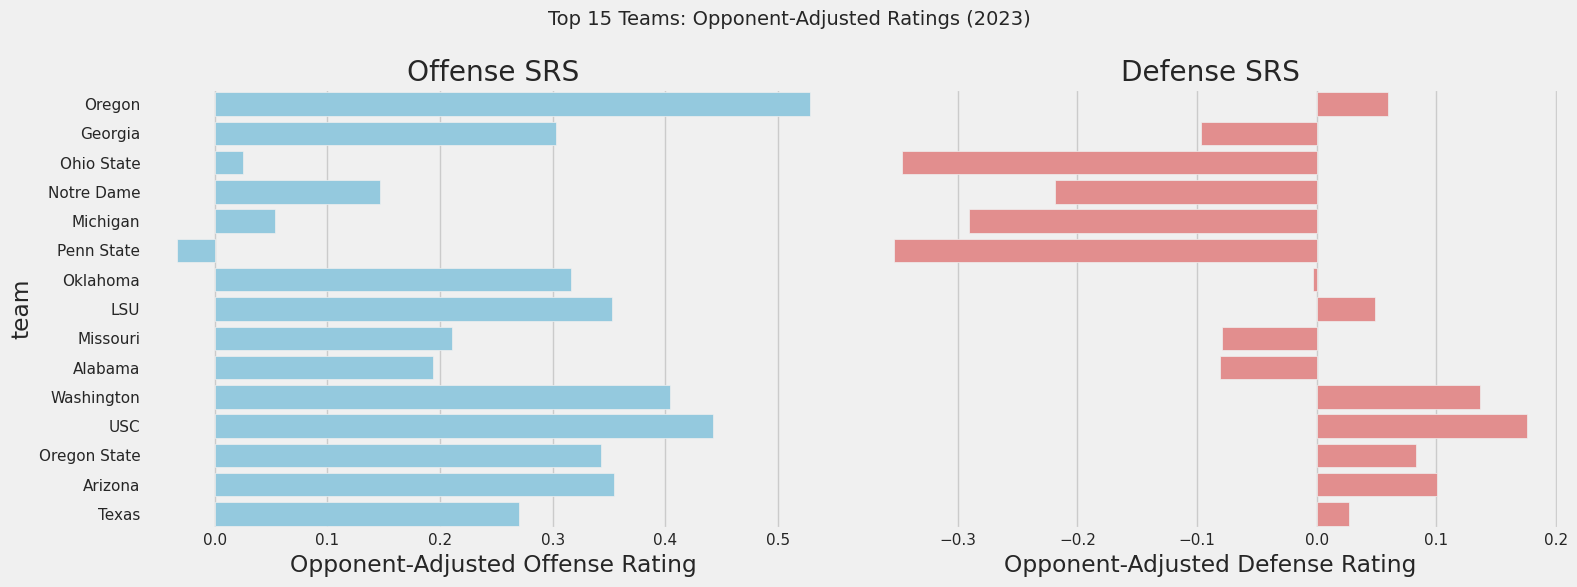

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

top = srs_df.head(15)

sns.barplot(data=top, x="offense_srs", y="team", ax=axes[0], color="skyblue")
axes[0].set_title("Offense SRS")
axes[0].set_xlabel("Opponent-Adjusted Offense Rating")

sns.barplot(data=top, x="defense_srs", y="team", ax=axes[1], color="lightcoral")
axes[1].set_title("Defense SRS")
axes[1].set_xlabel("Opponent-Adjusted Defense Rating")

plt.suptitle("Top 15 Teams: Opponent-Adjusted Ratings (2023)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Summary

# In this notebook, you:
# - Estimated true offensive and defensive ratings using opponent-adjusted SRS
# - Solved a system of equations for each side of the ball
# - Created net ratings for overall team strength
# - Visualized and compared results across teams

# 🧪 Try This:
# - Weight games by opponent strength or margin
# - Filter to games from later in the season
# - Add tempo adjustment (EPA/play × plays/game)